### Cifar-10 with other models

In [1]:
# -*- coding: utf-8 -*-
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torchvision.transforms as transforms

import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import sys

In [2]:
# check GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device)

GPU state: cuda:0


### Load datasets

In [3]:
# Method 2
# Load from pre-saved datasets, use unpickle function
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
# Load from original datasets
# return train_data[50000, 3072] and labels[50000]
#        test_data[10000, 3072] and labels[10000]

def get_data(train=False):
    data = None
    labels = None
    if train == True:
        for i in range(1,6):    
            batch = unpickle('./data/cifar-10-batches-py/data_batch_'+str(i))
            if (i == 1):
                data   = batch[b'data']
                labels = batch[b'labels']
            else:
                data   = np.concatenate([data,batch[b'data']])
                labels = np.concatenate([labels,batch[b'labels']])
                
    else:
        batch  = unpickle('./data/cifar-10-batches-py/test_batch')
        data   = batch[b'data']
        labels = batch[b'labels']
    return data, labels

In [5]:
'''
自定義資料集讀取框架來載入cifar10資料集
需要繼承data.Dataset
'''
class Cifar10_Dataset(Data.Dataset):
    def __init__(self, train=True, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        
        # Load training datasets
        if self.train:
            self.train_data,self.train_labels = get_data(train)
            self.train_data = self.train_data.reshape((50000, 3, 32, 32))
            self.train_data = self.train_data.transpose((0, 2, 3, 1)) 
        
        # Load testing datasets
        else:
            self.test_data,self.test_labels = get_data()
            self.test_data = self.test_data.reshape((10000, 3, 32, 32))
            self.test_data = self.test_data.transpose((0, 2, 3, 1))
        pass
    def __getitem__(self, index):
        #從資料集中讀取一個數據並對資料進行
        #預處理返回一個數據對，如（data,label）
        if self.train:
            img, label = self.train_data[index], self.train_labels[index]
        else:
            img, label = self.test_data[index], self.test_labels[index]
        
        img = Image.fromarray(img)
        
        # imgae preprocessing
        if self.transform is not None:
            img = self.transform(img)
        # label preprocessing
        if self.target_transform is not None:
            target = self.target_transform(label)
 
        return img, target
    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

In [6]:
def target_transform(label):
    label  = np.array(label)
    target = torch.from_numpy(label).long()
    return target

In [7]:
transform_train_aug2 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test_aug2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [8]:
BATCH_SIZE = 64

In [9]:
train_data = Cifar10_Dataset(True, transform_train_aug2, target_transform)
print('size of train_data:{}'.format(train_data.__len__()))

test_data = Cifar10_Dataset(False, transform_test_aug2, target_transform)
print('size of test_data:{}'.format(test_data.__len__()))

train_loader = Data.DataLoader(dataset=train_data, batch_size = BATCH_SIZE, shuffle=True)
test_loader  = Data.DataLoader(dataset=test_data, batch_size = 100, shuffle=True)

size of train_data:50000
size of test_data:10000


In [10]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [11]:
## For progressing bar 
def progress_bar(num, total, start_time):
    rate = float(num)/total
    ratenum = int(100*rate)
    dur = time.perf_counter() - start_time

    r = '\r Progress:[{} {}] {}%, {:.2f}s'.format('*'*ratenum, ' '*(100-ratenum), ratenum, dur)
    sys.stdout.write(r)
    sys.stdout.flush()

In [12]:
def train_model(model, loss_func, optimizer, epoch, train_loader):
    training_loss = []
    training_accuracy = []
    correct_train = 0
    total_train = 0
    
    start_time = time.perf_counter()
    for i, (images, labels) in enumerate(train_loader):
        
        progress_bar(i+1, len(train_loader), start_time)
        
        train  = Variable(images).to(device)
        labels = Variable(labels).to(device)
            
        optimizer.zero_grad() # Clear gradients
        outputs = model(train)
        
        train_loss = loss_func(outputs, labels) # Calculate softmax and cross entropy loss

        train_loss.backward() # Calculate gradients
        optimizer.step()      # Update parameters
        
        predicted = torch.max(outputs.data, 1)[1] # Get predictions from the maximum value
        total_train += len(labels) # Total number of labels
        correct_train += (predicted == labels).float().sum() # Total correct predictions

    train_accuracy = 100 * correct_train / float(total_train)
    training_accuracy.append(train_accuracy)
    training_loss.append(train_loss.item())

    print(' Train --> Epoch：{}, Loss: {}, Acc: {:.6f}% '.format(epoch, train_loss.item(), train_accuracy)) 
    
    torch.cuda.empty_cache()
    
    return training_loss, training_accuracy

In [13]:
def evaluate(model, epoch, EPOCH, classes, test_loader, tmp_high, model_name):
    loss = []
    accuracy = []

    correct_test = 0
    total_test = 0
    conf_matrix = np.zeros((10, 10))
    class_correct = [0]*10
    class_total   = [0]*10
    
    tmp_high = tmp_high
    
    if model_name == None:
        print("Now for eval!")
    else:
        pass
    for (images, labels) in (test_loader):
            train = Variable(images).to(device)
            labels = Variable(labels).to(device)
            output = model(train)
            test_loss = loss_func(output, labels)
            pre = torch.max(output,1)[1]
            
            ## for confusion matrix 
            total_test += len(labels)
            correct_test += (pre == labels).float().sum()  
            correct_tensor = pre.eq(labels.data.view_as(pre))  # compare, return Tensor(True, True,....)
            correct = np.squeeze(correct_tensor.cpu().numpy()) # return (True, True,....)
        
            for i in range(labels.size(0)):
                label = labels.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        
                # Update confusion matrix
                conf_matrix[label][pre.data[i]] += 1
                
    test_accuracy = 100 * correct_test / float(total_test)
    accuracy.append(test_accuracy)
    loss.append(test_loss)
    
    print(' Test result --> Acc: {:.6f}%'.format(test_accuracy))
    
    
    if model_name != None:
        if test_accuracy > tmp_high:
            tmp_high = test_accuracy
            torch.save(model.state_dict(), './model/'+ model_name)
            print(" -> Save the best model & value so far ~")
        else:
            print(" Come on, keep going! ")
    else:
        pass
    
    if model_name != None:
        if (epoch == EPOCH): ## 不想每次都print 每個class的分類狀況 ##
            print(' Accuracy of each classes')
            for i in range(10):
                if class_total[i] > 0:
                    print(' Test Accuracy of {}: {}%, [{}/{}]' .format(
                        classes[i], 100 * class_correct[i] / class_total[i],
                        np.sum(class_correct[i]), np.sum(class_total[i]))
                            )
                else:
                    print(' Test Accuracy of {}: N/A (no training examples)' .format(classes[i]))
        else:
            None
    else:
        pass
    
    torch.cuda.empty_cache()
    
    return loss, accuracy, conf_matrix, tmp_high


### Load pre-trained LeNet
- with augmentation version 2
- train in practice 07

In [18]:
# Hyper-parameters
BATCH_SIZE = 64
EPOCH = 50
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99))
loss_func = nn.CrossEntropyLoss()

In [15]:
#Lenet Model structure define

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.Conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.Conv2 = nn.Conv2d(in_channels=6, out_channels=16,kernel_size=5)
        self.Activate = nn.ReLU()
        self.Pool = nn.MaxPool2d(2, 2)
        self.FC1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.FC2 = nn.Linear(120, 84)
        self.FC3 = nn.Linear(84, 10)
    
    def forward(self,x):
        x = self.Pool(self.Activate(self.Conv1(x)))
        x = self.Pool(self.Activate(self.Conv2(x)))
#         x = x.view(-1, 16*5*5)
        x = x.view(x.size()[0], -1)
        x = self.Activate(self.FC1(x))
        x = self.Activate(self.FC2(x))
        x = self.FC3(x)
        return x
    
model = LeNet().to(device)
from torchsummary import summary
summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [16]:
model = LeNet().to(device)
model.load_state_dict(torch.load('./model/Cifar-10_LeNet_best_with_aug1.pkl'))

<All keys matched successfully>

In [19]:
_, _, _, tmp_high_aug2 = evaluate(model, _, _, classes, test_loader, 0.0, None)

Now for eval!
 Test result --> Acc: 72.860001%


## Implement other models

### AlexNet  models (2012)
- 5 conv layers，3 FC layers

In [ ]:
class AlexNet(nn.Module): 
    def __init__(self):
        super(AlexNet, self).__init__()
        
        self.conv1 = nn.Sequential(  # input_size： 32 * 32 * 3
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1),  # (32-3+2)/1+1 = 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # output_size：(32-2)/2+1 = 16
        )
        self.conv2 = nn.Sequential(  # input_size： 16 * 16 * 6
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1), # output_size：(16-3+2)/1+1 = 16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # output_size：(16-2)/2+1 = 8
        )
        self.conv3 = nn.Sequential(  # input_size： 8 * 8 * 16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),# output_size：(8-3+2)/1+1 = 8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # output_size：(8-2)/2+1 = 4
        )
        self.conv4 = nn.Sequential(  # input_size： 4 * 4 * 64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),# output_size：(4-3+2)/1+1 = 4
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # output_size：(4-2)/2+1 = 2
        )
        self.conv5 = nn.Sequential(  # input_size： 2 * 2 * 128
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),# output_size：(2-3+2)/1+1 = 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # (2-2)/2+1 = 1
        )                            # output_size： 1 * 1 * 128
        
        self.dense = nn.Sequential(
            nn.Linear(128, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 128)
        x = self.dense(x)
        return x


In [14]:
model = AlexNet().to(device)
from torchsummary import summary
summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
              ReLU-2            [-1, 6, 32, 32]               0
         MaxPool2d-3            [-1, 6, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]             880
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]           4,640
              ReLU-8             [-1, 32, 8, 8]               0
         MaxPool2d-9             [-1, 32, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]          18,496
             ReLU-11             [-1, 64, 4, 4]               0
        MaxPool2d-12             [-1, 64, 2, 2]               0
           Conv2d-13            [-1, 128, 2, 2]          73,856
             ReLU-14            [-1, 12

In [19]:
BATCH_SIZE = 128
EPOCH = 50
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99))
loss_func = nn.CrossEntropyLoss()

In [20]:
save_model_name = 'Cifar-10_AlexNet.pkl'

train_loss_AlexNet = []
train_accur_AlexNet = []
test_loss_AlexNet = []
test_accur_AlexNet = []
tmp_high_AlexNet = 0

print("----Start training----" )
start = time.time()

for epoch in (range(1, EPOCH+1)):
    print('◆Epoch: [{}/{}]'.format(epoch, EPOCH) )
    model.train()
    loss_list, accur_list = train_model(model, loss_func, optimizer, epoch, train_loader)
    
    train_loss_AlexNet.append(loss_list)
    train_accur_AlexNet.append(accur_list)
    loss_list_AlexNet  = []
    accur_list_AlexNet = []
    
    print("--TESTING!!--")
    model.eval()
    loss_list, accur_list, conf_matrix, tmp_high_AlexNet = evaluate(model, epoch, EPOCH, classes, test_loader, 
                                                            tmp_high_AlexNet, save_model_name)
    test_loss_AlexNet.append(loss_list)
    test_accur_AlexNet.append(accur_list)
    print(" --> Highest testing value so far：", tmp_high_AlexNet.item())
    del loss_list
    del accur_list
    
    torch.cuda.empty_cache()
    
end = time.time()
print("Excution time：%f sec" % (end - start))

----Start training----
◆Epoch: [1/50]
 Progress:[**************************************************************************************************** ] 100%, 21.47s Train --> Epoch：1, Loss: 1.0956733226776123, Acc: 75.026001% 
--TESTING!!--
 Test result --> Acc: 73.989998%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 73.98999786376953
◆Epoch: [2/50]
 Progress:[**************************************************************************************************** ] 100%, 20.23s Train --> Epoch：2, Loss: 0.6967712640762329, Acc: 75.173996% 
--TESTING!!--
 Test result --> Acc: 74.419998%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 74.41999816894531
◆Epoch: [3/50]
 Progress:[**************************************************************************************************** ] 100%, 20.16s Train --> Epoch：3, Loss: 0.7260209321975708, Acc: 75.458000% 
--TESTING!!--
 Test result --> Acc: 74.379997%
 Come on, keep going! 
 --> Highest 

 Test result --> Acc: 75.029999%
 Come on, keep going! 
 --> Highest testing value so far： 75.4000015258789
◆Epoch: [26/50]
 Progress:[**************************************************************************************************** ] 100%, 19.35s Train --> Epoch：26, Loss: 0.701408326625824, Acc: 77.075996% 
--TESTING!!--
 Test result --> Acc: 75.809998%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 75.80999755859375
◆Epoch: [27/50]
 Progress:[**************************************************************************************************** ] 100%, 19.48s Train --> Epoch：27, Loss: 0.6124423742294312, Acc: 77.119995% 
--TESTING!!--
 Test result --> Acc: 74.949997%
 Come on, keep going! 
 --> Highest testing value so far： 75.80999755859375
◆Epoch: [28/50]
 Progress:[**************************************************************************************************** ] 100%, 19.36s Train --> Epoch：28, Loss: 0.583882212638855, Acc: 77.178001% 
--TESTING!!-

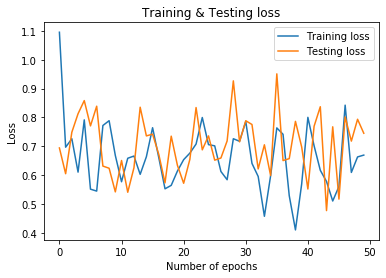

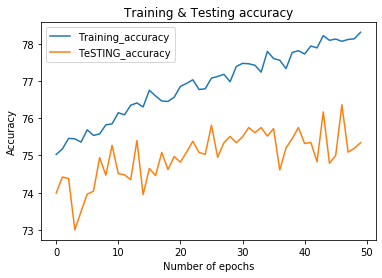

In [21]:
plt.plot(train_loss_AlexNet, label='Training loss')
plt.plot(test_loss_AlexNet,  label='Testing loss')
plt.title('Training & Testing loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accur_AlexNet, label='Training_accuracy')
plt.plot(test_accur_AlexNet,  label='TeSTING_accuracy')
plt.title('Training & Testing accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### VGGNet  models  (2014)
- Here use VGG-16
- 5 CONV layers + 3FC layers

In [13]:
## gerneral define method ##

class VGGNet(nn.Module):
    def __init__(self, vgg_arch, num_classes):
        super(VGGNet, self).__init__()
        self.features = self.vgg_block(vgg_arch)
        self.Activate = nn.ReLU(inplace=True)
        
        self.fc1 = nn.Linear(in_features=512, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=1024)
        self.fc3 = nn.Linear(in_features=1024, out_features=num_classes)

    def vgg_block(self, vgg_arch):
        layers = []
        in_channels = 3 

        for v in vgg_arch:
            if v == "M":
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

            else:
                layers.append(nn.Conv2d(in_channels=in_channels, out_channels=v, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True)) 
                in_channels = v

        return nn.Sequential(*layers)       

    def forward(self, x):
        x = self.features(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.Activate(self.fc1(x))
        x = self.Activate(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
## Detail define method ## 

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # CONV3-64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # CONV3-64
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #CONV3-128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # CONV3-128
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # CONV3-256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # CONV3-256
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # CONV3-256 with MaxPool
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # CONV3-512
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # CONV3-512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # CONV3-512 with MaxPool
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # CONV3-512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # CONV3-512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # CONV3-512 with MaxPool
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AvgPool2d(kernel_size=1, stride=1),
            )
        
        self.classifier = nn.Sequential(
            # FC-4096
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            # FC-4096
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            
            # FC-1000
            nn.Linear(4096, num_classes),
            )
 
    def forward(self, x):
        out = self.features(x) 
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [14]:
vgg_arch16 = [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"]
model = VGGNet(vgg_arch16, 10).to(device)
from torchsummary import summary
summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [16]:
BATCH_SIZE = 128
EPOCH = 50
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99))
loss_func = nn.CrossEntropyLoss()

In [17]:
save_model_name = 'Cifar-10_VGG16.pkl'

train_loss_VGG16 = []
train_accur_VGG16 = []
test_loss_VGG16 = []
test_accur_VGG16 = []
tmp_high_VGG16 = 0

print("----Start training----" )
start = time.time()

for epoch in (range(1, EPOCH+1)):
    print('◆Epoch: [{}/{}]'.format(epoch, EPOCH) )
    model.train()
    loss_list, accur_list = train_model(model, loss_func, optimizer, epoch, train_loader)
    
    train_loss_VGG16.append(loss_list)
    train_accur_VGG16.append(accur_list)
    loss_list_AlexNet  = []
    accur_list_AlexNet = []
    
    print("--TESTING!!--")
    model.eval()
    loss_list, accur_list, conf_matrix, tmp_high_VGG16 = evaluate(model, epoch, EPOCH, classes, test_loader, 
                                                            tmp_high_VGG16, save_model_name)
    test_loss_VGG16.append(loss_list)
    test_accur_VGG16.append(accur_list)
    print(" --> Highest testing value so far：", tmp_high_VGG16.item())
    del loss_list
    del accur_list
    
    torch.cuda.empty_cache()
    
end = time.time()
print("Excution time：%f sec" % (end - start))

----Start training----
◆Epoch: [1/50]
 Progress:[**************************************************************************************************** ] 100%, 21.62s Train --> Epoch：1, Loss: 1.8639838695526123, Acc: 19.515999% 
--TESTING!!--
 Test result --> Acc: 26.939999%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 26.939998626708984
◆Epoch: [2/50]
 Progress:[**************************************************************************************************** ] 100%, 21.27s Train --> Epoch：2, Loss: 1.6312925815582275, Acc: 30.261999% 
--TESTING!!--
 Test result --> Acc: 34.290001%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 34.290000915527344
◆Epoch: [3/50]
 Progress:[**************************************************************************************************** ] 100%, 21.65s Train --> Epoch：3, Loss: 1.4803338050842285, Acc: 41.349998% 
--TESTING!!--
 Test result --> Acc: 46.239998%
 -> Save the best model & value so

 Progress:[**************************************************************************************************** ] 100%, 21.39s Train --> Epoch：25, Loss: 0.5300441384315491, Acc: 84.823997% 
--TESTING!!--
 Test result --> Acc: 82.939995%
 Come on, keep going! 
 --> Highest testing value so far： 83.55999755859375
◆Epoch: [26/50]
 Progress:[**************************************************************************************************** ] 100%, 21.33s Train --> Epoch：26, Loss: 0.4250606894493103, Acc: 86.465996% 
--TESTING!!--
 Test result --> Acc: 83.629997%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 83.62999725341797
◆Epoch: [27/50]
 Progress:[**************************************************************************************************** ] 100%, 20.99s Train --> Epoch：27, Loss: 0.46078237891197205, Acc: 87.045998% 
--TESTING!!--
 Test result --> Acc: 84.619995%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 84.6199951

 Test result --> Acc: 85.750000%
 Come on, keep going! 
 --> Highest testing value so far： 87.29000091552734
◆Epoch: [50/50]
 Progress:[**************************************************************************************************** ] 100%, 21.21s Train --> Epoch：50, Loss: 0.49531397223472595, Acc: 88.568001% 
--TESTING!!--
 Test result --> Acc: 82.909996%
 Come on, keep going! 
 Accuracy of each classes
 Test Accuracy of plane: 82.7%, [827/1000]
 Test Accuracy of car: 92.2%, [922/1000]
 Test Accuracy of bird: 71.2%, [712/1000]
 Test Accuracy of cat: 57.7%, [577/1000]
 Test Accuracy of deer: 87.3%, [873/1000]
 Test Accuracy of dog: 79.6%, [796/1000]
 Test Accuracy of frog: 87.6%, [876/1000]
 Test Accuracy of horse: 88.5%, [885/1000]
 Test Accuracy of ship: 89.1%, [891/1000]
 Test Accuracy of truck: 93.2%, [932/1000]
 --> Highest testing value so far： 87.29000091552734
Excution time：1253.641587 sec


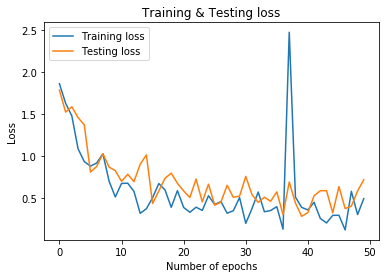

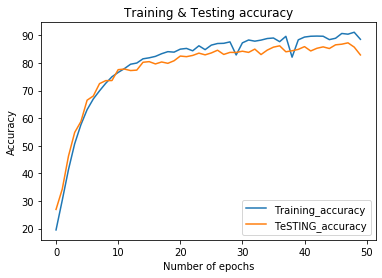

In [18]:
plt.plot(train_loss_VGG16, label='Training loss')
plt.plot(test_loss_VGG16,  label='Testing loss')
plt.title('Training & Testing loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accur_VGG16, label='Training_accuracy')
plt.plot(test_accur_VGG16,  label='TeSTING_accuracy')
plt.title('Training & Testing accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### CNN models

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.CONV_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            #Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.FC_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        # conv layers
        x = self.CONV_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.FC_layer(x)

        return x

In [14]:
model = CNN().to(device)
from torchsummary import summary
summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
             ReLU-11          [-1, 128, 16, 16]               0
        MaxPool2d-12            [-1, 128, 8, 8]               0
        Dropout2d-13            [-1, 128, 8, 8]               0
           Conv2d-14            [-1, 25

In [ ]:
BATCH_SIZE = 128
EPOCH = 50
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99))
loss_func = nn.CrossEntropyLoss()

In [17]:
save_model_name = 'Cifar-10_CNN_three_layer.pkl'

train_loss_CNN = []
train_accur_CNN = []
test_loss_CNN = []
test_accur_CNN = []
tmp_high_CNN = 0

print("----Start training----" )
start = time.time()

for epoch in (range(1, EPOCH+1)):
    print('◆Epoch: [{}/{}]'.format(epoch, EPOCH) )
    model.train()
    loss_list, accur_list = train_model(model, loss_func, optimizer, epoch, train_loader)
    
    train_loss_CNN.append(loss_list)
    train_accur_CNN.append(accur_list)
    loss_list_CNN  = []
    accur_list_CNN = []
    
    print("--TESTING!!--")
    model.eval()
    loss_list, accur_list, conf_matrix, tmp_high_CNN = evaluate(model, epoch, EPOCH, classes, test_loader, 
                                                            tmp_high_CNN, save_model_name)
    test_loss_CNN.append(loss_list)
    test_accur_CNN.append(accur_list)
    print(" --> Highest testing value so far：", tmp_high_CNN.item())
    del loss_list
    del accur_list
    
    torch.cuda.empty_cache()
    
end = time.time()
print("Excution time：%f sec" % (end - start))

----Start training----
◆Epoch: [1/50]
 Progress:[**************************************************************************************************** ] 100%, 20.57s Train --> Epoch：1, Loss: 1.2593036890029907, Acc: 40.475998% 
--TESTING!!--
 Test result --> Acc: 55.009998%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 55.0099983215332
◆Epoch: [2/50]
 Progress:[**************************************************************************************************** ] 100%, 19.79s Train --> Epoch：2, Loss: 0.9960950613021851, Acc: 59.265999% 
--TESTING!!--
 Test result --> Acc: 63.219997%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 63.21999740600586
◆Epoch: [3/50]
 Progress:[**************************************************************************************************** ] 100%, 19.71s Train --> Epoch：3, Loss: 0.9390538334846497, Acc: 66.297997% 
--TESTING!!--
 Test result --> Acc: 69.699997%
 -> Save the best model & value so fa

 Progress:[**************************************************************************************************** ] 100%, 20.20s Train --> Epoch：50, Loss: 0.19691690802574158, Acc: 92.923996% 
--TESTING!!--
 Test result --> Acc: 88.669998%
 -> Save the best model & value so far ~
 Accuracy of each classes
 Test Accuracy of plane: 86.6%, [866/1000]
 Test Accuracy of car: 92.5%, [925/1000]
 Test Accuracy of bird: 83.3%, [833/1000]
 Test Accuracy of cat: 80.4%, [804/1000]
 Test Accuracy of deer: 85.4%, [854/1000]
 Test Accuracy of dog: 86.8%, [868/1000]
 Test Accuracy of frog: 92.6%, [926/1000]
 Test Accuracy of horse: 92.7%, [927/1000]
 Test Accuracy of ship: 92.8%, [928/1000]
 Test Accuracy of truck: 93.6%, [936/1000]
 --> Highest testing value so far： 88.66999816894531
Excution time：1173.119604 sec


In [17]:
del model 
torch.cuda.empty_cache()

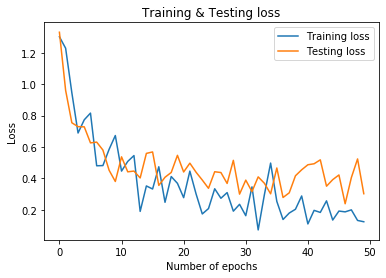

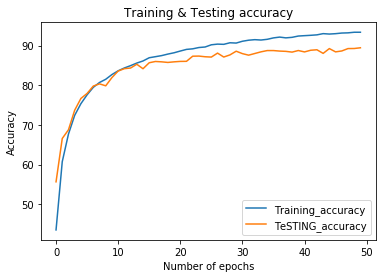

In [18]:
plt.plot(train_loss_CNN, label='Training loss')
plt.plot(test_loss_CNN,  label='Testing loss')
plt.title('Training & Testing loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accur_CNN, label='Training_accuracy')
plt.plot(test_accur_CNN,  label='TeSTING_accuracy')
plt.title('Training & Testing accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()plt.plot(train_loss_CNN, label='Training loss')
plt.plot(test_loss_CNN,  label='Testing loss')
plt.title('Training & Testing loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accur_CNN, label='Training_accuracy')
plt.plot(test_accur_CNN,  label='TeSTING_accuracy')
plt.title('Training & Testing accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Compare Result table

In [4]:
from texttable import Texttable
print("Compare Reult with 50 epoch")
tb=Texttable()
tb.set_cols_align(['l', 'c', 'c', 'c', 'c'])
tb.set_cols_dtype(['t', 'f', 'f', 'f', 'f'])
tb.add_rows([['Version', 'LeNet with augmentation', 'AlexNet', 'VGG-16',  '3 layers CNN'],
            ["Best Accuracy (%)", tmp_high_LeNET, tmp_high_AlexNet, tmp_high_VGG16, tmp_high_CNN_3L],
            ])
print(tb.draw())

Compare Reult with 50 epoch
+-------------------+------------------------+---------+--------+--------------+
|      Version      |       LeNet with       | AlexNet | VGG-16 | 3 layers CNN |
|                   |      augmentation      |         |        |              |
+===================+========================+=========+========+==============+
| Best Accuracy (%) |         72.860         | 76.360  | 87.290 |    88.670    |
+-------------------+------------------------+---------+--------+--------------+
